### debug DCC

In [1]:
import os
import sys
import numpy as np
from itertools import combinations

In [2]:
def dynamic_corr(func_file):
    """calculate garch-dcc"""
    sj_mat = np.load(os.path.join(func_file))
    comb = list(combinations(np.arange(sj_mat.shape[1]),2))
    # calculate dcc
    dcc_ls = []
    for c in comb:
        t1 = sj_mat[:,c[0]]
        t2 = sj_mat[:,c[1]]
        dcc_out = calc_dcc(t1, t2)
        dcc_ls.append(dcc_out)
    dcc_sj = np.stack(dcc_ls)
    print(dcc_sj.shape)
    # save correlation
    tmp = func_file.split('/')
    path_name = tmp[:-1]
    file_name = tmp[-1].split('.')[0]
    output_dir = os.path.join(*path_name)
    save_dir = os.path.join(output_dir, 'dynamic_corr')
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    file_name = file_name+'_dcc.npy'
    output_file = os.path.join(save_dir, file_name)
    np.save(output_file, dcc_sj)
    print(f'dcc output saved to {output_file}')
    return dcc_sj


def calc_dcc(t1, t2):
    """calcualte dcc between 2 time series"""
    from DCC_GARCH.GARCH import GARCH, garch_loss_gen
    t1_model = GARCH(1,1)
    t1_model.set_loss(garch_loss_gen(1,1))
    t1_model.set_max_itr(1)
    t1_model.fit(t1)
    t1_sigma = t1_model.sigma(t1)
    t1_epsilon = t1/t1_sigma

    t2_model = GARCH(1,1)
    t2_model.set_loss(garch_loss_gen(1,1))
    t2_model.set_max_itr(1)
    t2_model.fit(t2)
    t2_sigma = t2_model.sigma(t2)
    t2_epsilon = t2/t2_sigma    

    epsilon = np.array([t1_epsilon, t2_epsilon])

    from DCC_GARCH.DCC import DCC, dcc_loss_gen, R_gen
    dcc_model = DCC()
    dcc_model.set_loss(dcc_loss_gen())
    dcc_model.fit(epsilon)

    # get DCC R (conditional correlation matrix)
    ab = dcc_model.get_ab()
    tr = epsilon
    R_ls = R_gen(tr,ab)
    R = np.array(R_ls)
    # flatten Rt
    K = R.shape[1]
    Rt_triu = R[:,np.triu(np.ones((K,K)),1)>0].T
    dcc_out = Rt_triu[0]
    # print(dcc_out.shape)
    # import matplotlib.pyplot as plt
    # plt.plot(dcc_out)
    # plt.savefig('./test.png')
    return dcc_out

In [3]:
func_file = '../output/msdl/s01_rest_func.npy'

In [5]:
# dynamic_corr(func_file)

In [8]:
infile = np.load(func_file)

In [9]:
infile.shape

(230, 39)

In [18]:
out = np.load('../output/yeo/dynamic_corr/s01_pain_func_dcc.npy')

In [19]:
out.shape

(136, 230)

In [20]:
39*38/2

741.0

In [21]:
import matplotlib.pyplot as plt

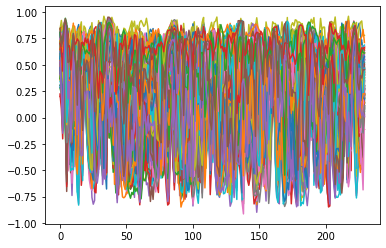

In [22]:
_=plt.plot(out.T)

In [23]:
tmp = np.load('../output/fan/static_corr/correlation_pain.npy')

In [24]:
tmp.shape

(11, 39060)